# 3 layer LSTM Encoder Decoder, dropout. 120 day input, 10 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras import regularizers

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [17]:
save_dir = 'models/lstm4.63'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
num_skew_end = 15
data = df.values[:-num_skew_end]

In [18]:
num_input = 120
num_out = 10
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)


train_X shape (585, 120, 25)
train_y shape (585, 10, 1)
dev_X shape (69, 120, 25)
dev_y shape (69, 10, 1)
test_X shape (35, 120, 25)
test_y shape (35, 10, 1)
train_y_acc shape (585, 10, 1)
dev_y_acc shape (69, 10, 1)
test_y_acc shape (35, 10, 1)


In [5]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.0005
decay = 1e-6
dropout_rate = 0.3
epochs = 1000
batch_size = 32

model = Sequential()
model.add(CuDNNLSTM(200, input_shape=input_shape))
model.add(Dropout(dropout_rate))
model.add(RepeatVector(num_out))
model.add(CuDNNLSTM(200, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mse", optimizer=opt)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 200)               181600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 200)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 10, 200)           321600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 200)           0         
_________________________________________________________________
time_distributed_1 (T

In [6]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 1000 epochs, 32 batch size
Instructions for updating:
Use tf.cast instead.
Train on 563 samples, validate on 70 samples
Epoch 1/1000
563/563 [==============================] - 2s 4ms/step - loss: 0.0334 - val_loss: 0.0271
Epoch 2/1000
563/563 [==============================] - 1s 1ms/step - loss: 0.0119 - val_loss: 0.0085
Epoch 3/1000
563/563 [==============================] - 1s 1ms/step - loss: 0.0083 - val_loss: 0.0078
Epoch 4/1000
563/563 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 0.0050
Epoch 5/1000
563/563 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 6/1000
563/563 [==============================] - 1s 1ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 7/1000
563/563 [==============================] - 1s 1ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 8/1000
563/563 [==============================] - 1s 1ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 9/1000
563/563 [=========

Epoch 77/1000
563/563 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 78/1000
563/563 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 9.4656e-04
Epoch 79/1000
563/563 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 80/1000
563/563 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 81/1000
563/563 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 82/1000
563/563 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 83/1000
563/563 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 84/1000
563/563 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 85/1000
563/563 [==============================] - 1s 1ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 86/1000
563/563 [==============================] - 1s 1ms/step 

563/563 [==============================] - 1s 1ms/step - loss: 7.1182e-04 - val_loss: 0.0013
Epoch 153/1000
563/563 [==============================] - 1s 1ms/step - loss: 6.9581e-04 - val_loss: 0.0012
Epoch 154/1000
563/563 [==============================] - 1s 1ms/step - loss: 6.8447e-04 - val_loss: 8.5402e-04
Epoch 155/1000
563/563 [==============================] - 1s 1ms/step - loss: 6.5201e-04 - val_loss: 0.0012
Epoch 156/1000
563/563 [==============================] - 1s 1ms/step - loss: 6.5678e-04 - val_loss: 9.4558e-04
Epoch 157/1000
563/563 [==============================] - 1s 1ms/step - loss: 6.6446e-04 - val_loss: 8.5409e-04
Epoch 158/1000
563/563 [==============================] - 1s 1ms/step - loss: 6.4374e-04 - val_loss: 6.1310e-04
Epoch 159/1000
563/563 [==============================] - 1s 1ms/step - loss: 7.1067e-04 - val_loss: 8.7245e-04
Epoch 160/1000
563/563 [==============================] - 1s 1ms/step - loss: 7.2013e-04 - val_loss: 9.1605e-04
Epoch 161/1000
563/

563/563 [==============================] - 1s 1ms/step - loss: 5.6067e-04 - val_loss: 7.7272e-04
Epoch 226/1000
563/563 [==============================] - 1s 1ms/step - loss: 5.7200e-04 - val_loss: 6.6603e-04
Epoch 227/1000
563/563 [==============================] - 1s 1ms/step - loss: 6.3043e-04 - val_loss: 9.6500e-04
Epoch 228/1000
563/563 [==============================] - 1s 1ms/step - loss: 6.2692e-04 - val_loss: 5.7479e-04
Epoch 229/1000
563/563 [==============================] - 1s 1ms/step - loss: 6.1182e-04 - val_loss: 6.4066e-04
Epoch 230/1000
563/563 [==============================] - 1s 1ms/step - loss: 6.3332e-04 - val_loss: 8.0055e-04
Epoch 231/1000
563/563 [==============================] - 1s 1ms/step - loss: 5.5584e-04 - val_loss: 6.3332e-04
Epoch 232/1000
563/563 [==============================] - 1s 1ms/step - loss: 5.5890e-04 - val_loss: 0.0013
Epoch 233/1000
563/563 [==============================] - 1s 1ms/step - loss: 5.9581e-04 - val_loss: 8.4816e-04
Epoch 234/1

563/563 [==============================] - 1s 1ms/step - loss: 4.7570e-04 - val_loss: 6.7882e-04
Epoch 299/1000
563/563 [==============================] - 1s 1ms/step - loss: 5.8350e-04 - val_loss: 5.0529e-04
Epoch 300/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.9650e-04 - val_loss: 4.9308e-04
Epoch 301/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.6860e-04 - val_loss: 6.0579e-04
Epoch 302/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.5734e-04 - val_loss: 4.9427e-04
Epoch 303/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.8376e-04 - val_loss: 5.5685e-04
Epoch 304/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.8962e-04 - val_loss: 7.3738e-04
Epoch 305/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.6766e-04 - val_loss: 5.5026e-04
Epoch 306/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.9517e-04 - val_loss: 9.9798e-04
Epoch 3

563/563 [==============================] - 1s 1ms/step - loss: 3.9601e-04 - val_loss: 5.5032e-04
Epoch 372/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.3220e-04 - val_loss: 4.7519e-04
Epoch 373/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.6908e-04 - val_loss: 5.6047e-04
Epoch 374/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.8960e-04 - val_loss: 5.8982e-04
Epoch 375/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.4479e-04 - val_loss: 5.0991e-04
Epoch 376/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.2292e-04 - val_loss: 6.6171e-04
Epoch 377/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.3583e-04 - val_loss: 4.9880e-04
Epoch 378/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.4409e-04 - val_loss: 3.9985e-04
Epoch 379/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.3380e-04 - val_loss: 8.7280e-04
Epoch 3

563/563 [==============================] - 1s 1ms/step - loss: 4.0536e-04 - val_loss: 4.5899e-04
Epoch 445/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.2308e-04 - val_loss: 8.0628e-04
Epoch 446/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.3301e-04 - val_loss: 4.6396e-04
Epoch 447/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.2486e-04 - val_loss: 6.0500e-04
Epoch 448/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.8869e-04 - val_loss: 4.3874e-04
Epoch 449/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.4227e-04 - val_loss: 5.4651e-04
Epoch 450/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.2723e-04 - val_loss: 4.8707e-04
Epoch 451/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.2422e-04 - val_loss: 7.4363e-04
Epoch 452/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.0698e-04 - val_loss: 5.9602e-04
Epoch 4

563/563 [==============================] - 1s 1ms/step - loss: 3.8294e-04 - val_loss: 5.6816e-04
Epoch 518/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.4407e-04 - val_loss: 5.0888e-04
Epoch 519/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.4759e-04 - val_loss: 6.1084e-04
Epoch 520/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.3763e-04 - val_loss: 5.3924e-04
Epoch 521/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.5549e-04 - val_loss: 4.3486e-04
Epoch 522/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.5397e-04 - val_loss: 4.9619e-04
Epoch 523/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.5921e-04 - val_loss: 5.2430e-04
Epoch 524/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.4598e-04 - val_loss: 4.3111e-04
Epoch 525/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.5241e-04 - val_loss: 4.5646e-04
Epoch 5

563/563 [==============================] - 1s 1ms/step - loss: 3.3176e-04 - val_loss: 3.5768e-04
Epoch 591/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.1987e-04 - val_loss: 3.6303e-04
Epoch 592/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.3535e-04 - val_loss: 4.9755e-04
Epoch 593/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.3180e-04 - val_loss: 3.8814e-04
Epoch 594/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.2822e-04 - val_loss: 3.5908e-04
Epoch 595/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.5696e-04 - val_loss: 3.4759e-04
Epoch 596/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.3254e-04 - val_loss: 6.6674e-04
Epoch 597/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.7305e-04 - val_loss: 5.3363e-04
Epoch 598/1000
563/563 [==============================] - 1s 1ms/step - loss: 4.6918e-04 - val_loss: 4.8771e-04
Epoch 5

563/563 [==============================] - 1s 1ms/step - loss: 3.0968e-04 - val_loss: 5.1717e-04
Epoch 664/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.9289e-04 - val_loss: 4.1680e-04
Epoch 665/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.9487e-04 - val_loss: 4.6253e-04
Epoch 666/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.9278e-04 - val_loss: 4.5235e-04
Epoch 667/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.9452e-04 - val_loss: 5.1060e-04
Epoch 668/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.9616e-04 - val_loss: 4.5146e-04
Epoch 669/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.1566e-04 - val_loss: 7.1564e-04
Epoch 670/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.3348e-04 - val_loss: 4.3755e-04
Epoch 671/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.9767e-04 - val_loss: 4.0393e-04
Epoch 6

563/563 [==============================] - 1s 1ms/step - loss: 2.6458e-04 - val_loss: 2.5703e-04
Epoch 737/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.4051e-04 - val_loss: 5.1331e-04
Epoch 738/1000
563/563 [==============================] - 1s 1ms/step - loss: 3.2406e-04 - val_loss: 3.8703e-04
Epoch 739/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.9921e-04 - val_loss: 3.3595e-04
Epoch 740/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.9313e-04 - val_loss: 3.9525e-04
Epoch 741/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.7248e-04 - val_loss: 3.7093e-04
Epoch 742/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.6869e-04 - val_loss: 2.4868e-04
Epoch 743/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.7000e-04 - val_loss: 2.9623e-04
Epoch 744/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.7040e-04 - val_loss: 3.7040e-04
Epoch 7

563/563 [==============================] - 1s 1ms/step - loss: 2.7068e-04 - val_loss: 3.7977e-04
Epoch 810/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.7366e-04 - val_loss: 2.8093e-04
Epoch 811/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.5787e-04 - val_loss: 2.0686e-04
Epoch 812/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.5149e-04 - val_loss: 3.5644e-04
Epoch 813/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.4755e-04 - val_loss: 3.2066e-04
Epoch 814/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.5198e-04 - val_loss: 3.2521e-04
Epoch 815/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.4475e-04 - val_loss: 3.3112e-04
Epoch 816/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.2846e-04 - val_loss: 2.5481e-04
Epoch 817/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.4047e-04 - val_loss: 2.5650e-04
Epoch 8

563/563 [==============================] - 1s 1ms/step - loss: 2.1247e-04 - val_loss: 2.4339e-04
Epoch 883/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.2124e-04 - val_loss: 2.3110e-04
Epoch 884/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.0135e-04 - val_loss: 2.2048e-04
Epoch 885/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.0356e-04 - val_loss: 3.1194e-04
Epoch 886/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.1803e-04 - val_loss: 2.3359e-04
Epoch 887/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.0442e-04 - val_loss: 2.5786e-04
Epoch 888/1000
563/563 [==============================] - 1s 1ms/step - loss: 1.9876e-04 - val_loss: 2.3259e-04
Epoch 889/1000
563/563 [==============================] - 1s 1ms/step - loss: 1.9621e-04 - val_loss: 2.8819e-04
Epoch 890/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.0635e-04 - val_loss: 2.8279e-04
Epoch 8

563/563 [==============================] - 1s 1ms/step - loss: 2.0856e-04 - val_loss: 2.8122e-04
Epoch 956/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.0445e-04 - val_loss: 3.0251e-04
Epoch 957/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.1047e-04 - val_loss: 2.9462e-04
Epoch 958/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.0354e-04 - val_loss: 1.8923e-04
Epoch 959/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.2123e-04 - val_loss: 2.7184e-04
Epoch 960/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.3481e-04 - val_loss: 2.9857e-04
Epoch 961/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.1688e-04 - val_loss: 2.1340e-04
Epoch 962/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.1486e-04 - val_loss: 2.9825e-04
Epoch 963/1000
563/563 [==============================] - 1s 1ms/step - loss: 2.0298e-04 - val_loss: 3.1116e-04
Epoch 9

In [7]:
preds_train = model.predict(train_X).squeeze()
preds_dev = model.predict(dev_X).squeeze()
preds_test = model.predict(test_X).squeeze()
print("MSE Train:", mean_squared_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MSE Dev:", mean_squared_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MSE Test:", mean_squared_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

MSE Train: 0.00022279384462614725
MSE Dev: 0.0004065167258994811
MSE Test: 0.0009344310663104178


In [36]:
# Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Dev'], loc='upper left')
# plt.show()
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

l = go.Scatter(y=history.history['loss'], name='train')
v = go.Scatter(y=history.history['val_loss'], name='dev')

data = [v,l]
py.iplot(data, filename='line-mode')

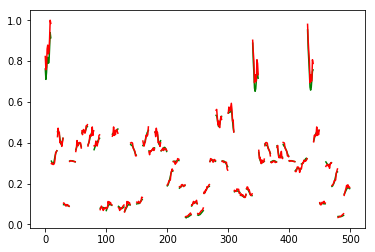

In [9]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_train.tolist()[:50], [], num_out, baseline_data=true_train.tolist()[:50])

# predicted_train = model.predict(train_X).squeeze()
# predicted_train = predicted_train[:, 0].reshape(-1,1)
# true_train = train_y[:, 0].reshape(-1,1)
# utils.plot_results(predicted_train[:50], true_train[:50])

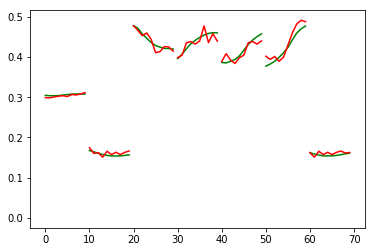

In [11]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_dev.tolist(), [0], num_out, baseline_data=true_dev.tolist())

# predicted_dev = model.predict(dev_X).squeeze()
# predicted_dev = predicted_dev[:, 0].reshape(-1,1)
# true_dev = dev_y[:, 0].reshape(-1,1)
# utils.plot_results(predicted_dev, true_dev)

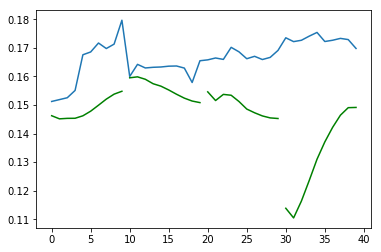

In [29]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[::num_out].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

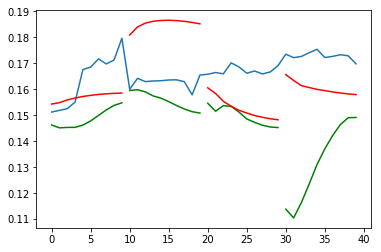

VAR MAE Test: 0.014679061944746335
LSTM MAE Test: 0.02020658227161188


In [25]:
var_preds = utils.var_predict(test_X[:, :, 0:5], num_out)
var_preds = var_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=var_preds.tolist())

print("VAR MAE Test:", mean_absolute_error(var_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


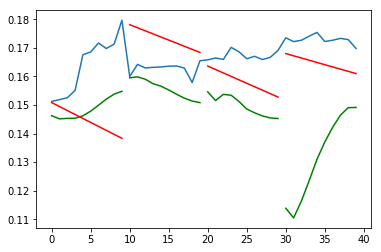

ARIMA MAE Test: 0.011817364924727753
LSTM MAE Test: 0.02020658227161188


In [26]:
arima_preds = utils.arima_predict(test_X[:, :, 0], num_out)
arima_preds = arima_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=arima_preds.tolist())

print("ARIMA MAE Test:", mean_absolute_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

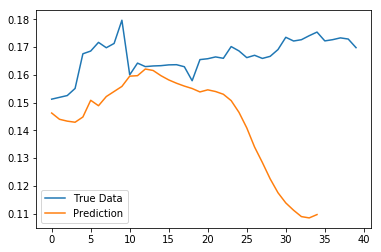

In [33]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[:, 0]
utils.plot_results(predicted_test, true_test)

In [32]:
# print("MSE Train:", mean_squared_error(predicted_train.reshape(-1,1), true_train))
# print("MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))
# print("MSE Test:", mean_squared_error(predicted_test, true_test))
# print("MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

ValueError: Found input variables with inconsistent numbers of samples: [35, 40]

In [18]:
print("Acc Train:", utils.direction_accuracy(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("Acc Dev:", utils.direction_accuracy(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("Acc Test:", utils.direction_accuracy(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

Acc Train: 0.8606701940035273
Acc Dev: 0.5285714285714286
Acc Test: 0.5070422535211268


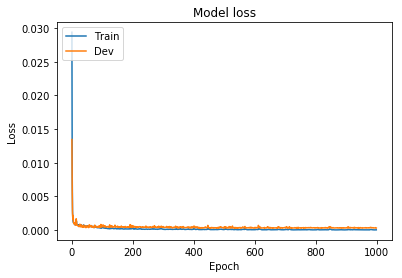

In [29]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()